In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [6]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [7]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [18]:
learning_rate = 0.0001
training_iters = 4400000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.25 # Dropout, probability to keep units

# network config

In [15]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [10]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [19]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 3649767168.000000, Accuracy = 0.0300000030547
Performance on test set: Training epochs #1000, Batch Loss = 857804288.0, Accuracy = 0.00800000037998
Training epochs #20000: Batch Loss = 2452632832.000000, Accuracy = 0.0439999997616
Performance on test set: Training epochs #20000, Batch Loss = 463538336.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 1173373184.000000, Accuracy = 0.0900000035763
Performance on test set: Training epochs #40000, Batch Loss = 268730880.0, Accuracy = 0.0
Training epochs #60000: Batch Loss = 985481216.000000, Accuracy = 0.109000004828
Performance on test set: Training epochs #60000, Batch Loss = 53141840.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 789531008.000000, Accuracy = 0.169000014663
Performance on test set: Training epochs #80000, Batch Loss = 69546824.0, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 1725993984.000000, Accuracy = 0.0509999990463
Performance on test set:

Training epochs #900000: Batch Loss = 232926560.000000, Accuracy = 0.097000002861
Performance on test set: Training epochs #900000, Batch Loss = 5197637.0, Accuracy = 0.943000078201
Training epochs #920000: Batch Loss = 32568284.000000, Accuracy = 0.588999986649
Performance on test set: Training epochs #920000, Batch Loss = 4874883.0, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 36569348.000000, Accuracy = 0.612999975681
Performance on test set: Training epochs #940000, Batch Loss = 5412980.5, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 30087110.000000, Accuracy = 0.638999938965
Performance on test set: Training epochs #960000, Batch Loss = 5727900.0, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 199824384.000000, Accuracy = 0.107999995351
Performance on test set: Training epochs #980000, Batch Loss = 4400712.5, Accuracy = 0.942999958992
Training epochs #1000000: Batch Loss = 28095832.000000, Accuracy = 0.600000023842
Performance

Training epochs #1800000: Batch Loss = 6860523.000000, Accuracy = 0.735000014305
Performance on test set: Training epochs #1800000, Batch Loss = 1211224.625, Accuracy = 0.949000000954
Training epochs #1820000: Batch Loss = 7084298.500000, Accuracy = 0.777000010014
Performance on test set: Training epochs #1820000, Batch Loss = 1261440.5, Accuracy = 0.943000078201
Training epochs #1840000: Batch Loss = 6425699.500000, Accuracy = 0.777000010014
Performance on test set: Training epochs #1840000, Batch Loss = 1305685.0, Accuracy = 0.943000018597
Training epochs #1860000: Batch Loss = 65933560.000000, Accuracy = 0.17499999702
Performance on test set: Training epochs #1860000, Batch Loss = 1061421.0, Accuracy = 0.949000060558
Training epochs #1880000: Batch Loss = 7426821.000000, Accuracy = 0.743999958038
Performance on test set: Training epochs #1880000, Batch Loss = 1097198.5, Accuracy = 0.949000060558
Training epochs #1900000: Batch Loss = 6261843.000000, Accuracy = 0.774000048637
Perform

Training epochs #2700000: Batch Loss = 3408251.250000, Accuracy = 0.809000015259
Performance on test set: Training epochs #2700000, Batch Loss = 427433.34375, Accuracy = 0.961000025272
Training epochs #2720000: Batch Loss = 2856649.500000, Accuracy = 0.838000059128
Performance on test set: Training epochs #2720000, Batch Loss = 453576.9375, Accuracy = 0.960999965668
Training epochs #2740000: Batch Loss = 30535154.000000, Accuracy = 0.256999969482
Performance on test set: Training epochs #2740000, Batch Loss = 292277.0, Accuracy = 0.949000000954
Training epochs #2760000: Batch Loss = 2458738.500000, Accuracy = 0.802999973297
Performance on test set: Training epochs #2760000, Batch Loss = 392147.875, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 3374887.000000, Accuracy = 0.816000044346
Performance on test set: Training epochs #2780000, Batch Loss = 405258.875, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 2260028.500000, Accuracy = 0.831999957561
Pe

Training epochs #3600000: Batch Loss = 896537.062500, Accuracy = 0.889000058174
Performance on test set: Training epochs #3600000, Batch Loss = 129166.984375, Accuracy = 0.967999994755
Training epochs #3620000: Batch Loss = 12747322.000000, Accuracy = 0.349000036716
Performance on test set: Training epochs #3620000, Batch Loss = 118089.148438, Accuracy = 0.982000112534
Training epochs #3640000: Batch Loss = 1240560.000000, Accuracy = 0.82900005579
Performance on test set: Training epochs #3640000, Batch Loss = 110409.695312, Accuracy = 0.982000112534
Training epochs #3660000: Batch Loss = 1999584.250000, Accuracy = 0.856000065804
Performance on test set: Training epochs #3660000, Batch Loss = 113255.851562, Accuracy = 0.982000052929
Training epochs #3680000: Batch Loss = 1120480.750000, Accuracy = 0.887000024319
Performance on test set: Training epochs #3680000, Batch Loss = 117214.078125, Accuracy = 0.982000052929
Training epochs #3700000: Batch Loss = 14070120.000000, Accuracy = 0.33

# performance visualization

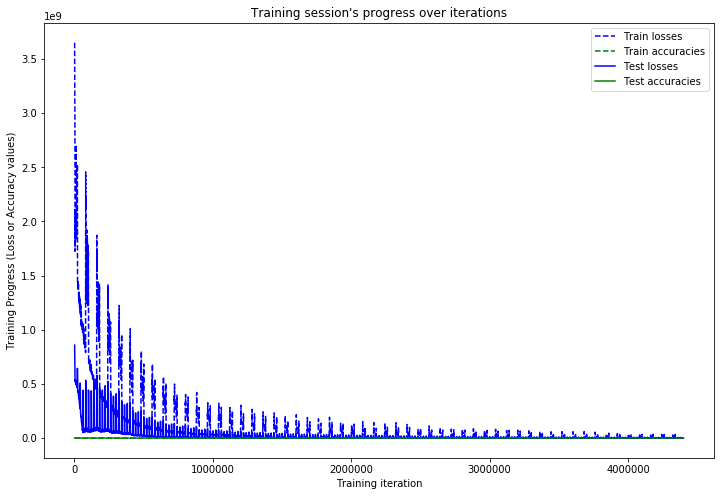

In [21]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 99.8000144958%

Precision: 93.273299838%
Recall: 93.175%
f1_score: 92.1291235175%

Confusion Matrix:
[[    0     8     0     0     0    10     0     0     0     0     0     0
      0]
 [    0   607     0     0    27   117   154     0     0     0     0     6
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   111     0     0  2734    10    33     0     0     0     0     3
      0]
 [    0    34     0     0     2   286    21     5     0     0     0     0
      0]
 [    0     9     0     0     0     0 14486     0     0     0     0     0
      0]
 [    0    37     0     0    38   333    89    30     0     0     0     8
      0]
 [    0     0     0     0     0     0     0     0     0     0     0   132
      0]
 [    0     4     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0   

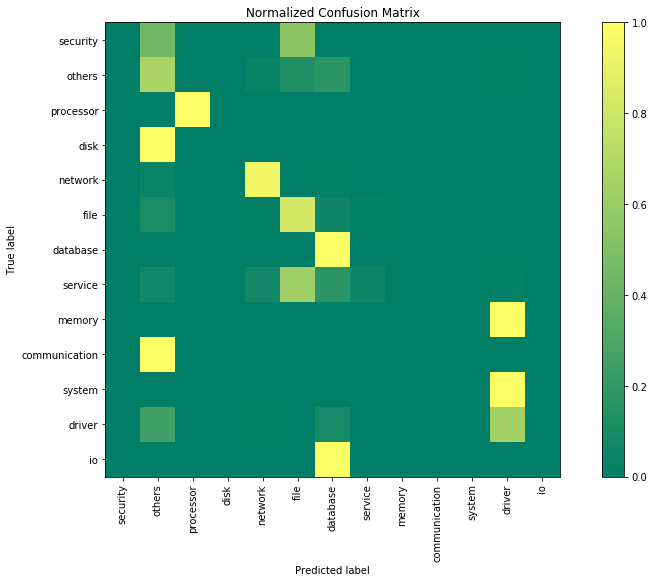

In [22]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)